Using device: cpu
Selected image: /Users/sadik2/main_project/test/neighbourhood/4/image/16.png
Selected image: /Users/sadik2/main_project/test/neighbourhood/4/image/83.png
Selected image: /Users/sadik2/main_project/test/neighbourhood/9/image/79.png
Selected image: /Users/sadik2/main_project/test/neighbourhood/9/image/85.png
Selected image: /Users/sadik2/main_project/test/neighbourhood/4/image/85.png


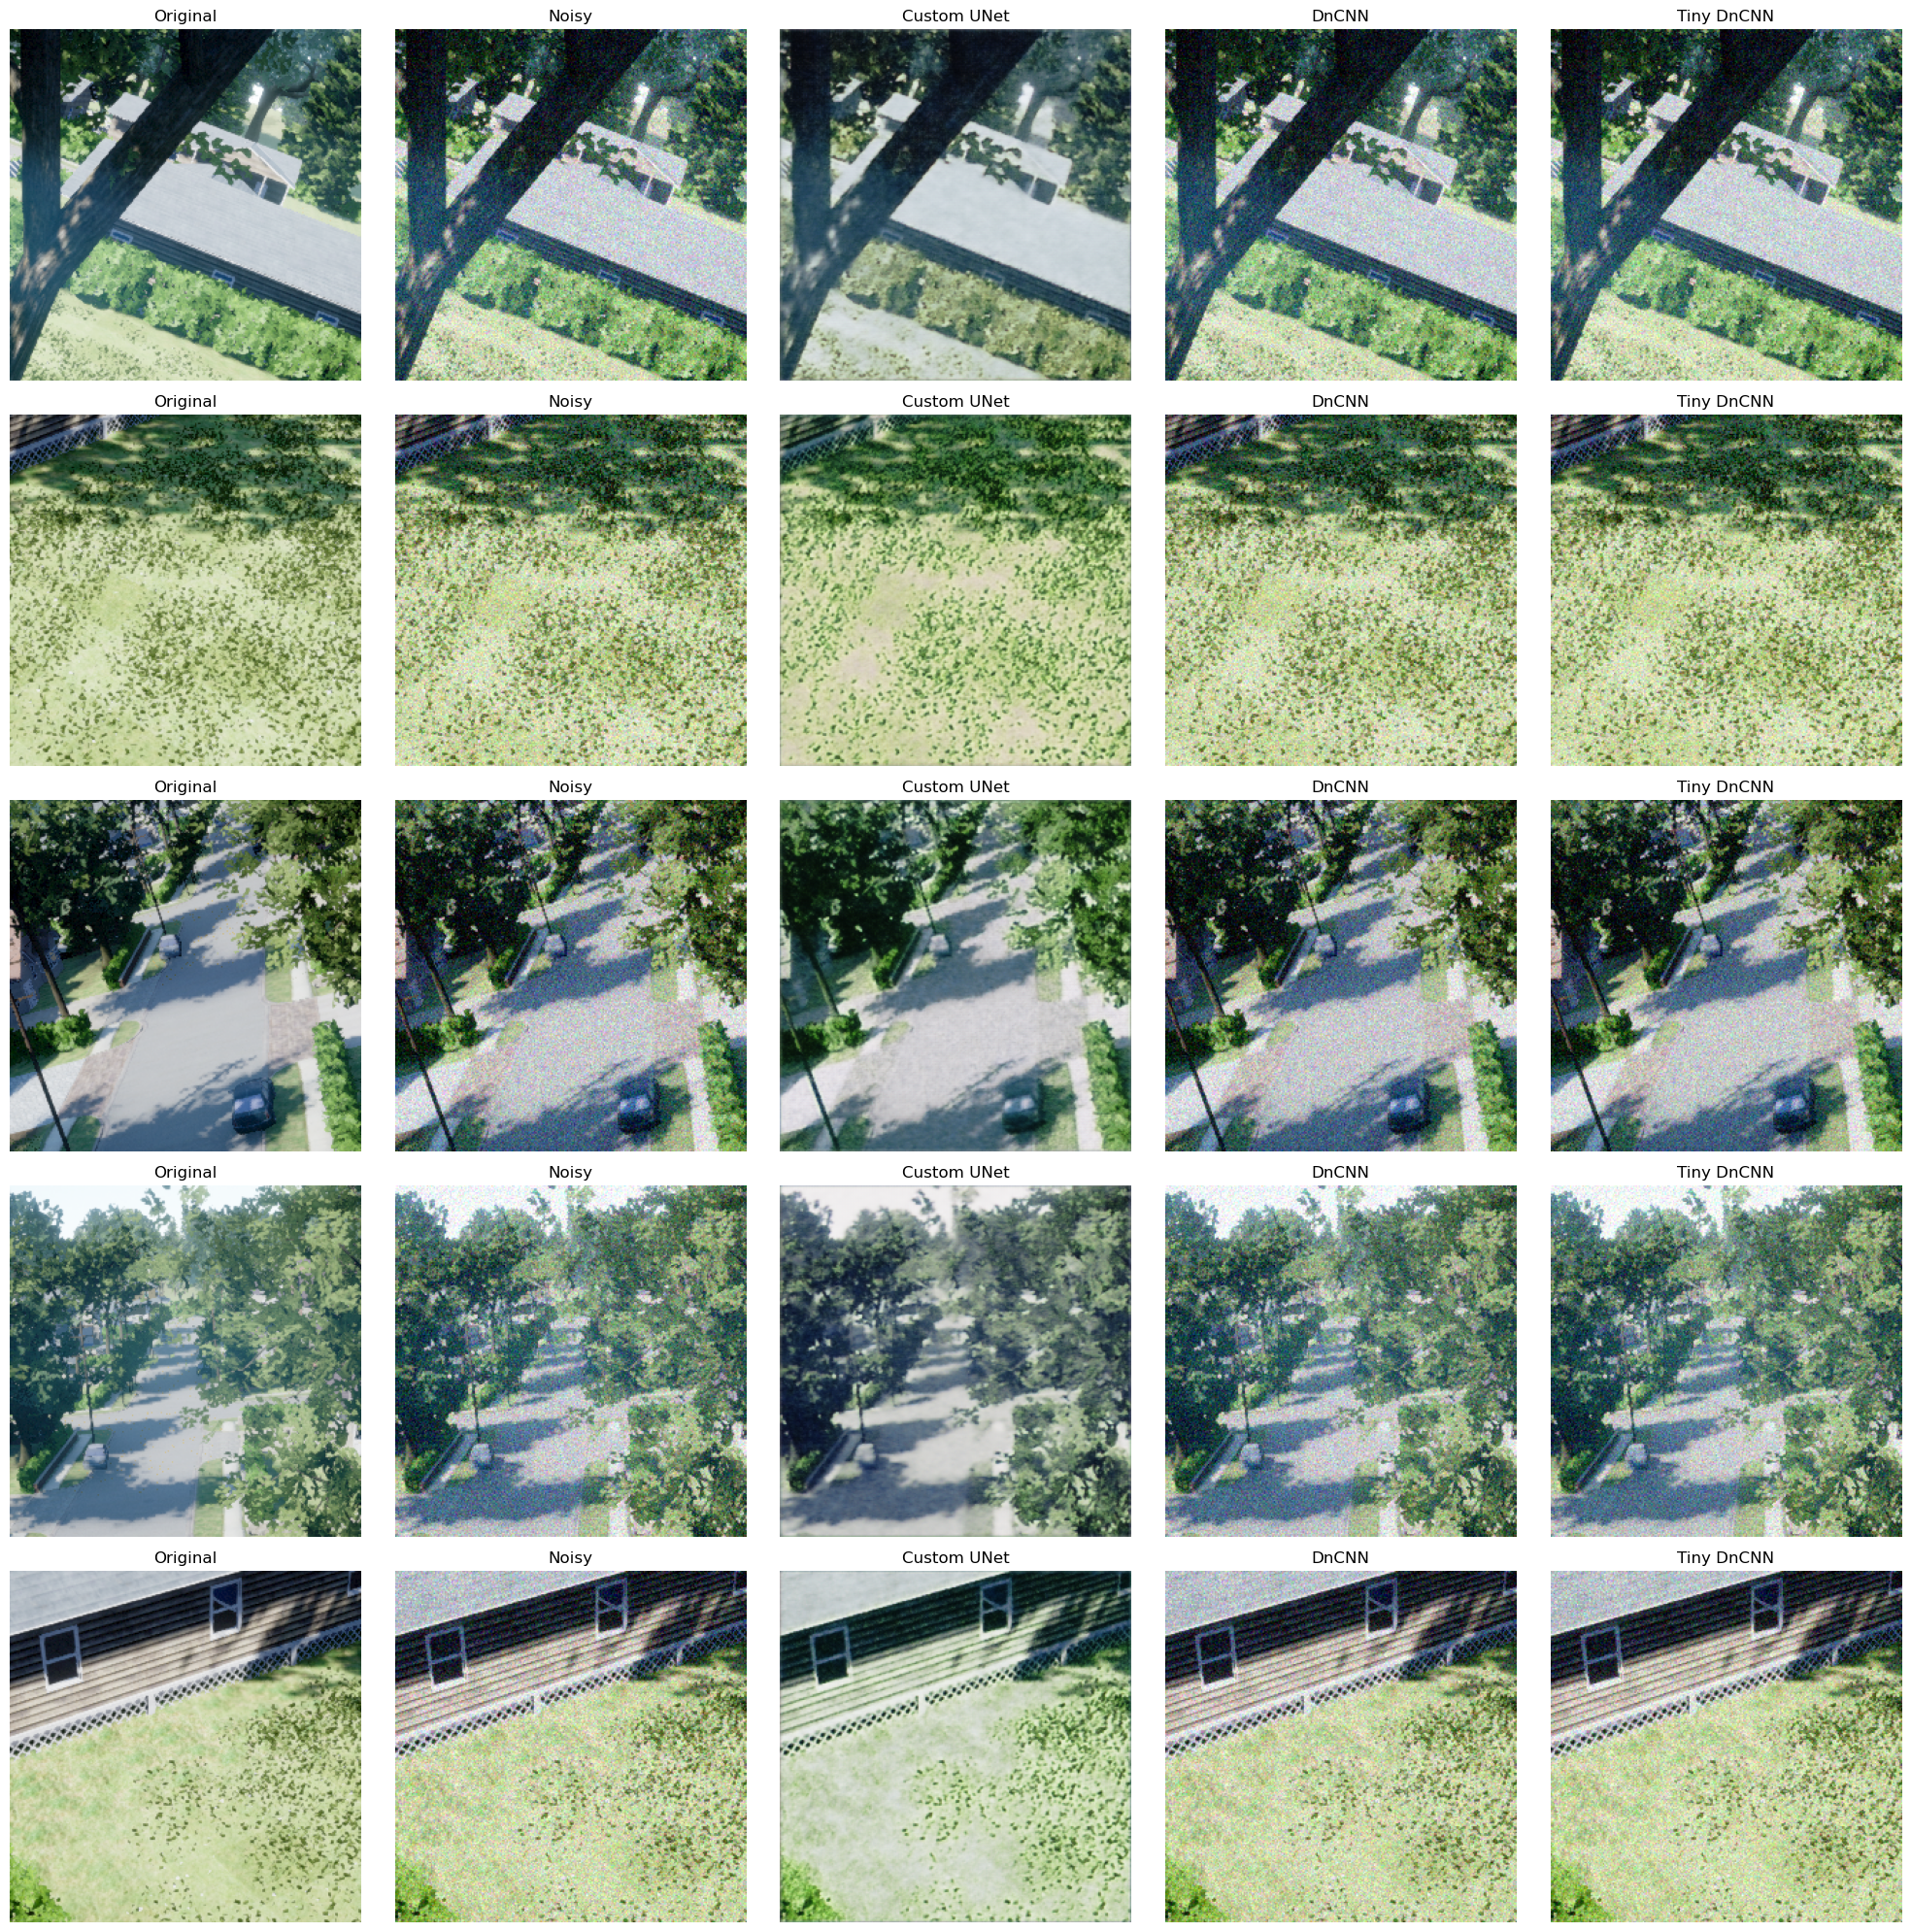

In [5]:
#!/usr/bin/env python3

import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T

# ----------------------------
# SETTINGS
# ----------------------------
TEST_DIR = "/Users/sadik2/main_project/test"
CHECKPOINT_PATH = "/Users/sadik2/main_project/checkpoints/checkpoint_epoch6.pth"
NUM_IMAGES = 5
IMAGE_SIZE = (256, 256)
NOISE_STD = 0.08
VALID_EXTS = (".png", ".PNG", ".jpg", ".jpeg", ".bmp")

# ----------------------------
# Helpers
# ----------------------------
def collect_image_paths(test_dir):
    test_dir = Path(test_dir)
    image_paths = []

    for top in ["neighbourhood", "park"]:
        base = test_dir / top
        if not base.exists():
            continue
        for img_dir in base.rglob("image"):
            for ext in VALID_EXTS:
                image_paths.extend(str(p.resolve()) for p in img_dir.glob(f"*{ext}"))

    if image_paths:
        return sorted(set(image_paths))
    for ext in VALID_EXTS:
        image_paths.extend(str(p.resolve()) for p in test_dir.rglob(f"*{ext}"))
    return sorted(set(image_paths))

def preprocess_pil(img, size):
    w, h = size
    if img.width < w or img.height < h:
        img = img.resize((w, h), Image.BILINEAR)
    else:
        left = (img.width - w) // 2
        top = (img.height - h) // 2
        img = img.crop((left, top, left + w, top + h))
    return T.ToTensor()(img)

def add_noise(tensor, std=NOISE_STD):
    noise = torch.randn_like(tensor) * std
    return torch.clamp(tensor + noise, 0.0, 1.0)

# ----------------------------
# Models
# ----------------------------
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_layers=17):
        super().__init__()
        layers = [nn.Conv2d(channels,64,3,padding=1), nn.ReLU(True)]
        for _ in range(num_layers-2):
            layers += [nn.Conv2d(64,64,3,padding=1,bias=False), nn.BatchNorm2d(64), nn.ReLU(True)]
        layers.append(nn.Conv2d(64,channels,3,padding=1,bias=False))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return torch.clamp(x - self.net(x),0.0,1.0)

class TinyDnCNN(nn.Module):
    def __init__(self, channels=3, num_layers=5):
        super().__init__()
        layers = [nn.Conv2d(channels,32,3,padding=1), nn.ReLU(True)]
        for _ in range(num_layers-2):
            layers += [nn.Conv2d(32,32,3,padding=1,bias=False), nn.BatchNorm2d(32), nn.ReLU(True)]
        layers.append(nn.Conv2d(32,channels,3,padding=1,bias=False))
        self.net = nn.Sequential(*layers)
    def forward(self,x): return torch.clamp(x - self.net(x),0.0,1.0)

class DoubleConv(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,out_ch,3,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch,out_ch,3,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self,x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if identity.shape[1] != out.shape[1]:
            conv1x1 = nn.Conv2d(identity.shape[1], out.shape[1], 1).to(out.device)
            identity = conv1x1(identity)
        out += identity
        return self.relu(out)

class UNet(nn.Module):
    def __init__(self,in_channels=3,out_channels=3,features=(64,128,256,512)):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for f in features:
            self.downs.append(DoubleConv(in_channels,f))
            in_channels=f
        self.pool = nn.MaxPool2d(2,2)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        rev_features = features[::-1]
        up_in = features[-1]*2
        for f in rev_features:
            self.ups.append(nn.ConvTranspose2d(up_in,f,2,stride=2))
            self.ups.append(DoubleConv(up_in,f))
            up_in = f
        self.final_conv = nn.Conv2d(features[0], out_channels,1)
    def forward(self,x):
        skip_connections = []
        out = x
        for down in self.downs:
            out = down(out)
            skip_connections.append(out)
            out = self.pool(out)
        out = self.bottleneck(out)
        skip_connections = skip_connections[::-1]
        up_idx = 0
        for i in range(0,len(self.ups),2):
            trans = self.ups[i]
            double = self.ups[i+1]
            out = trans(out)
            skip = skip_connections[up_idx]
            up_idx += 1
            if skip.shape[2:] != out.shape[2:]:
                h_min = (skip.shape[2]-out.shape[2])//2
                w_min = (skip.shape[3]-out.shape[3])//2
                skip = skip[:,:,h_min:h_min+out.shape[2],w_min:w_min+out.shape[3]]
            out = torch.cat([skip,out], dim=1)
            out = double(out)
        return torch.sigmoid(self.final_conv(out))

def load_checkpoint(model, path, device):
    ckpt = torch.load(path,map_location=device)
    if isinstance(ckpt,dict):
        state = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
    else:
        state = ckpt
    model.load_state_dict(state)
    return model

# ----------------------------
# Random image comparison
# ----------------------------
def compare_random_images(test_dir, checkpoint_path, device, num_images=NUM_IMAGES):
    paths = collect_image_paths(test_dir)
    selected_paths = random.sample(paths, min(num_images, len(paths)))
    
    custom_model = UNet().to(device)
    load_checkpoint(custom_model, checkpoint_path, device)
    custom_model.eval()
    
    dncnn = DnCNN().to(device).eval()
    tiny_dncnn = TinyDnCNN().to(device).eval()
    
    fig, axes = plt.subplots(len(selected_paths), 5, figsize=(20, 4*len(selected_paths)))
    
    def to_np(t): return t.squeeze(0).cpu().permute(1,2,0).numpy()
    
    for row_idx, img_path in enumerate(selected_paths):
        print(f"Selected image: {img_path}")
        img = Image.open(img_path).convert("RGB")
        clean_t = preprocess_pil(img, IMAGE_SIZE).unsqueeze(0).to(device)
        noisy_t = add_noise(clean_t)
        
        with torch.no_grad():
            out_custom = custom_model(noisy_t)
            out_dncnn = dncnn(noisy_t)
            out_tiny = tiny_dncnn(noisy_t)
        
        images = [clean_t, noisy_t, out_custom, out_dncnn, out_tiny]
        titles = ["Original","Noisy","Custom UNet","DnCNN","Tiny DnCNN"]
        
        for col_idx, (img_tensor, title) in enumerate(zip(images, titles)):
            axes[row_idx, col_idx].imshow(to_np(img_tensor))
            axes[row_idx, col_idx].set_title(title)
            axes[row_idx, col_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__=="__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    compare_random_images(TEST_DIR, CHECKPOINT_PATH, device)
